<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining (QBUS6810)</h1>
<h2 align="center" style="margin-top:10px">Tutorial 5: Model Selection</h2>
<br>


In this tutorial we go back to the <TT>Credit</TT> dataset to introduce model selection into the data analysis process. By using cross validation, we can pick the number of neighbours in KNN before generating predictions for the test data. 


<a href="#Credit-Card-Data">Credit Card Data</a> <br>
<a href="#Training-and-Test-Sets">Training and Test Sets</a> <br>
<a href="#Data-Preparation">Data Preparation</a> <br>
<a href="#Parameter-Tuning">Parameter Tuning</a> <br>
<a href="#Model-Selection">Model Selection</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>
<a href="#Practice">Practice</a> <br>

In [4]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # this is to clear the warnings from this page, usually we should leave them on

In [5]:
# Plot settings
sns.set_context('notebook') # optimise figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

## Credit Card Data

We will again work with the <TT>Credit</TT> dataset, which you can download from Canvas. The objective is to predict the average monthly credit card balance of customers based on predictors such as income, age, education, and credit rating. The dataset records the average credit card balace at end of the month for customers of a financial services company, as well as other individual characteristics such age, education, gender, marital status, number of cards, and credit rating.

We start by loading and viewing the data, as before.

In [6]:
# We will always assume that the data file is in a subdirectory called "Datasets"

data=pd.read_csv('Datasets/Credit.csv', index_col='Obs')
data.head(10)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
Obs,,,,,,,,,,,
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
6,80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151
7,20.996,3388,259,2,37,12,Female,No,No,African American,203
8,71.408,7114,512,2,87,9,Male,No,No,Asian,872
9,15.125,3300,266,5,66,13,Female,No,No,Caucasian,279


## Training and Test Sets

As before, we use the Scikit-Learn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html" target="_blank"><TT>train_test_split</TT></a> method to split the data into training and test sets. 

In [7]:
from sklearn.model_selection import train_test_split

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=1)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

## Data Preparation

In most cases, we need to performe additional processing to get the data ready for training machine learning models and computing predictions. It is good practice to write a function for this step. 

Here we replace the categorical predictors with the corresponding dummy variables.

In [8]:
def prepare_data(df):
    df['Male']=(df['Gender'] ==' Male').astype(int) # create dummy variable for gender
    df['Student']=(df['Student'] =='Yes').astype(int)
    df['Married']=(df['Married'] =='Yes').astype(int)
    df['Caucasian']=(df['Ethnicity'] =='Caucasian').astype(int)
    df['Asian']=(df['Ethnicity'] =='Asian').astype(int)
    df=df.loc[:, df.dtypes!='object'] # discards the columns that are not numerical
    return df

train = prepare_data(train)
test = prepare_data(test)

train.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Balance,Male,Caucasian,Asian
Obs,,,,,,,,,,,,
40,13.647,3461,264,4,47,14,0,1,344,1,1,0
168,29.403,2327,178,1,37,14,0,1,0,0,1,0
384,14.292,3274,282,9,64,9,0,1,382,1,1,0
222,98.515,8760,633,5,78,11,0,0,1230,0,0,0
352,61.620,5140,374,1,71,9,0,1,302,1,1,0


We need to identify and separate the response and the predictors. As before, We start with just one predictor: customer's credit card Limit. 

In [9]:
# Construting response vector and design matrix (matrix of predictor values) 
response = 'Balance'
predictors = ['Limit'] # in general we will be working with a list of predictors, even though we only have one here

# If we wanted to use all available predictors, we could define predictors as follows: 
# predictors = [variable for variable in train.columns if variable!=response]

y_train = train[response] # selects the response variable
X_train=train[predictors].copy() # selects the variables in the predictor list

y_test = test[response]
X_test=test[predictors].copy()

<br>
## Methods

As before, we will use linear regression and k-nearest neighbours in our analysis.

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

<br>
## Parameter Tuning

We now have two important questions:

1) How many neighbours should we use in the KNN method?

2) Should we use linear regression or the KNN algorithm to poduce our final model?

We use [cross validation](http://scikit-learn.org/stable/modules/cross_validation.html) to estimate the generalisation performance of different model choices. For concreteness, we refer to choosing the parameter as tuning, and to the choice of the method as model selection.

To select the number of neighbours, we need to specify a grid of candidate values and select the specification with best cross validation performance. The Scikit-Learn [<TT>GridSearchCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) method conveniently automates this process. We will follow the template below.

In [13]:
from sklearn.model_selection import GridSearchCV

model = KNeighborsRegressor() 
    
tuning_parameters = {
    'n_neighbors': np.arange(1,51),
}

knn_search =  GridSearchCV(model, tuning_parameters, cv=5,  scoring = 'neg_mean_squared_error', 
                           return_train_score=False, n_jobs=4)
knn_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

Note that we specified the following options: 

<li style="margin-top: 12px;"><TT>cv=5</TT> specifies the number of folds. </li>

<li style="margin-top: 12px;"><TT>scoring = 'neg_mean_squared_error'</TT> specifies the evaluation criterion (it does not change the outcome here, but it is useful have this option as a template). </li>

<li style="margin-top: 12px;"><TT>return_train_score=False</TT> speeds up the computations by avoiding unnecessary calculations (this is set to become the default in future versions). </li>

<li style="margin-top: 12px;"><TT>n_jobs=4</TT> splits the task across four processor cores, speeding up the computations. </li>
<br><br>
We can access the following attribute to view the selected value of the parameter: 

In [14]:
knn_search.best_params_

{'n_neighbors': 15}

<br>
The selected model is stored in the best estimator attribute: 

In [15]:
knn_search.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=15, p=2,
          weights='uniform')

<br>
*** Randomized search ***

Performing a full grid search may become too computationally costly when we work with large datasets and/or methods that have multiple tuning parameters. In this case, we could instead use the  [<TT>RandomizedSearchCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) function, which evaluates only a random subset of parameter combinations. 

The syntax is very similar to the above, except that we will often want to specify the <TT>n_iter</TT> option in order to control the computational budget for the parameter seach. Below, we specify that we would like to try twenty values for the number of neighbours. 

In [16]:
from sklearn.model_selection import RandomizedSearchCV

model = KNeighborsRegressor() 

tuning_parameters = {
    'n_neighbors': np.arange(1,101),
}

knn_rs =  RandomizedSearchCV(model, tuning_parameters, cv=5,  n_iter=20, scoring = 'neg_mean_squared_error',
                             return_train_score=False, n_jobs=4)
knn_rs.fit(X_train, y_train)
knn_rs.best_params_ # because of the random search, the result may be different from what we got before

{'n_neighbors': 16}

<br>
*** Cross-calidation scores ***

Now, suppose that we want to compute the cross-validation score for a given model. The syntax is as follows. 

In [18]:
knn = KNeighborsRegressor(n_neighbors=15) 

from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
scores

array([-39639.23531746, -64949.6281746 , -32186.12992063, -64467.13825397,
       -48064.20285714])

The [<TT>cross_val_score</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function returns the scores for each fold. Below, we average the scores and obtain the cross validation root mean squared error. 

In [19]:
np.sqrt(-1*np.mean(scores))

223.2963656326764

The scoring in Scikit-Learn follows the convention that higher score values are better than lower values. This is why the argument in the function is the negative mean squared error . The Scikit-Learn [model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html) documentation provides a list of scoring options. You should save this for future reference.

Often, the syntax is simplified by the fact that each method in Scikit-Learn has a default scoring method. In this case you have to consult the documentation to know what it is. For a [KNN regression the default scoring is the r-squared](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor).

We can do the following to plot the cross validation error as a function of the tuning parameter. 

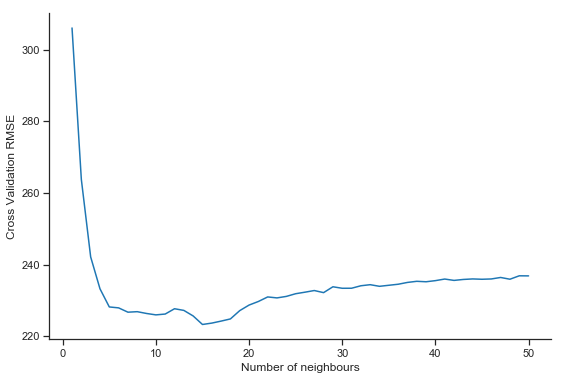

Lowest CV error: K = 15


In [20]:
neighbours=np.arange(1, 51)

cv_rmse = []
for k in neighbours: 
    model = KNeighborsRegressor(n_neighbors= k) 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    cv_rmse.append(rmse)

fig, ax= plt.subplots()
ax.plot(neighbours, cv_rmse)
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Cross Validation RMSE')
sns.despine()
plt.show()
  
print(f'Lowest CV error: K = {1 + np.argmin(cv_rmse)}')   

<br>
## Model Selection

We now turn to model selection based on the cross-validation results. We use the [<TT>cross_val_predict</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) function and show the CV results for two evaluation metrics. We could also apply the <TT>cross_val_score</TT> function to build this type of table, but this is slower when using multiple metrics. 

Here we see that KNN has a lower cross-validation error than OLS.  Note that the number of neighbours in KNN was selected earlier by the GridSearchCV method.

In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Re-specifying the two models
ols = LinearRegression()
knn = knn_search.best_estimator_

# Initialise table
columns=['RMSE', 'R-Squared']
rows=['Linear Regression', 'KNN']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List of algorithms
methods = [ols, knn] 

# Computer cross-validation predictions and metrics
for i, method in enumerate(methods):
    y_pred = cross_val_predict(method, X_train, y_train, cv=5, n_jobs=4)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_train, y_pred))
    results.iloc[i, 1] = r2_score(y_train, y_pred)

results.round(2)

,RMSE,R-Squared
Linear Regression,228.98,0.74
KNN,223.30,0.76


<br>
## Model Evaluation

We now assess the performance of our selected model on the **test** data, also displaying the linear regression results. The results confirm that we made a good choice by selecting the KNN as the model to predict new data. 

In [23]:
# Training
ols.fit(X_train, y_train)
knn.fit(X_train, y_train)

# Initialise table
columns=['RMSE', 'R-Squared']
rows=['Linear Regression', 'KNN']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols, knn] 

# Computer test predictions and metrics
for i, method in enumerate(methods):
    y_pred = method.predict(X_test)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i, 1] = r2_score(y_test, y_pred)

results.round(2)

,RMSE,R-Squared
Linear Regression,246.51,0.73
KNN,238.29,0.74


<br>

## Adding Predictors  

As in the previous tutorial, we will now add Income as the second predictor and repeat the analysis above.

In [29]:
predictors = ['Limit','Income'] 

X_train=train[predictors].copy() 
X_test=test[predictors].copy()

model = KNeighborsRegressor(metric='mahalanobis', metric_params={'V': X_train.cov()}) 
    
tuning_parameters = {
    'n_neighbors': np.arange(1,51),
}

knn_search =  GridSearchCV(model, tuning_parameters, cv=5,  scoring = 'neg_mean_squared_error', 
                           return_train_score=False, n_jobs=4)
knn_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='mahalanobis',
          metric_params={'V':                Limit        Income
Limit   5.064052e+06  61081.638149
Income  6.108164e+04   1194.601319},
          n_jobs=1, n_neighbors=5, p=2, weights='uniform'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

In [30]:
knn_search.best_params_

{'n_neighbors': 8}

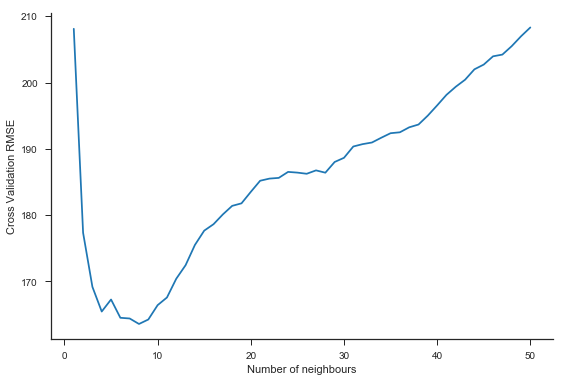

Lowest CV error: K = 8


In [32]:
neighbours=np.arange(1, 51)

cv_rmse = []
for k in neighbours: 
    model = KNeighborsRegressor(n_neighbors = k, metric='mahalanobis', metric_params={'V': X_train.cov()}) 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    cv_rmse.append(rmse)

fig, ax= plt.subplots()
ax.plot(neighbours, cv_rmse)
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Cross Validation RMSE')
sns.despine()
plt.show()
  
print(f'Lowest CV error: K = {1 + np.argmin(cv_rmse)}') 

<br>
*** Cross-validation performance: ***

In [33]:
# Re-specifying the two models
ols = LinearRegression()
knn = knn_search.best_estimator_

# Initialise table
columns=['RMSE', 'R-Squared']
rows=['Linear Regression', 'KNN']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List of algorithms
methods = [ols, knn] 

# Computer cross-validation predictions and metrics
for i, method in enumerate(methods):
    y_pred = cross_val_predict(method, X_train, y_train, cv=5, n_jobs=4)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_train, y_pred))
    results.iloc[i, 1] = r2_score(y_train, y_pred)

results.round(2)

,RMSE,R-Squared
Linear Regression,165.90,0.87
KNN,163.58,0.87


<br>
*** Test set performance: ***

In [34]:
# Training
ols.fit(X_train, y_train)
knn.fit(X_train, y_train)

# Initialise table
columns=['RMSE', 'R-Squared']
rows=['Linear Regression', 'KNN']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols, knn] 

# Computer test predictions and metrics
for i, method in enumerate(methods):
    y_pred = method.predict(X_test)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i, 1] = r2_score(y_test, y_pred)

results.round(2)

,RMSE,R-Squared
Linear Regression,168.12,0.87
KNN,159.26,0.89


## Practice

Try adding even more predictors and see how much improvement it can make. For example, the next two predictors with respect to the magnitude of their correlation with Balance are Student and Cards.